## **Extractive Dialogue Summarization**

### Load Data
Convert json files to pandas dataframes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import pandas as pd

file_path = "./drive/MyDrive/CS5246_Final_Project/data/"

# Read JSON file
with open(file_path + "train.json", "r", encoding="utf-8") as file:
    train_data = json.load(file)
with open(file_path + "val.json", "r", encoding="utf-8") as file:
    val_data = json.load(file)
with open(file_path + "test.json", "r", encoding="utf-8") as file:
    test_data = json.load(file)

# Convert to Pandas DataFrame
df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)
df_test = pd.DataFrame(test_data)

In [3]:
# Combine df_train and df_val
df_train = pd.concat([df_train, df_val])

### Data Examination

- Data size
- Whether there are missing values and duplicates
- Word count distribution

In [5]:
def describe_data(df):
  print(f"\nDataFrame shape: {df.shape}")
  print(f"\n{df.shape[0]:,.0f} samples")
  print(f'\nMissing Data: \n{df.isnull().sum()}')
  print(f'\nDuplicates: {df.duplicated().sum()}')

print("=========== Train data =============")
describe_data(df_train)

print("=========== Test data =============")
describe_data(df_test)

=========== Train data =============

DataFrame shape: (15550, 3)

15,550 samples

Missing Data: 
id          0
summary     0
dialogue    0
dtype: int64

Duplicates: 0
=========== Test data =============

DataFrame shape: (819, 3)

819 samples

Missing Data: 
id          0
summary     0
dialogue    0
dtype: int64

Duplicates: 0


In [6]:
df_train.head()

,id,summary,dialogue
0,13818513,Amanda baked cookies and will bring Jerry some...,Amanda: I baked cookies. Do you want some?\r\...
1,13728867,Olivia and Olivier are voting for liberals in ...,Olivia: Who are you voting for in this electio...
2,13681000,Kim may try the pomodoro technique recommended...,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa..."
3,13730747,Edward thinks he is in love with Bella. Rachel...,"Edward: Rachel, I think I'm in ove with Bella...."
4,13728094,"Sam is confused, because he overheard Rick com...",Sam: hey overheard rick say something\r\nSam:...


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_word_count_distribution(df):
  # Compute word counts
  df["dialogue_word_count"] = df["dialogue"].apply(lambda x: len(x.split()))
  df["summary_word_count"] = df["summary"].apply(lambda x: len(x.split()))

  # Create two subplots
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  # Box plot for Dialogue word counts
  sns.boxplot(y=df["dialogue_word_count"], ax=axes[0], color="skyblue")
  axes[0].set_title("Dialogue Word Count Distribution")
  axes[0].set_ylabel("Word Count")

  # Box plot for Summary word counts
  sns.boxplot(y=df["summary_word_count"], ax=axes[1], color="lightcoral")
  axes[1].set_title("Summary Word Count Distribution")
  axes[1].set_ylabel("Word Count")

  # Show plots
  plt.tight_layout()
  plt.show()

Train data word count distribution:


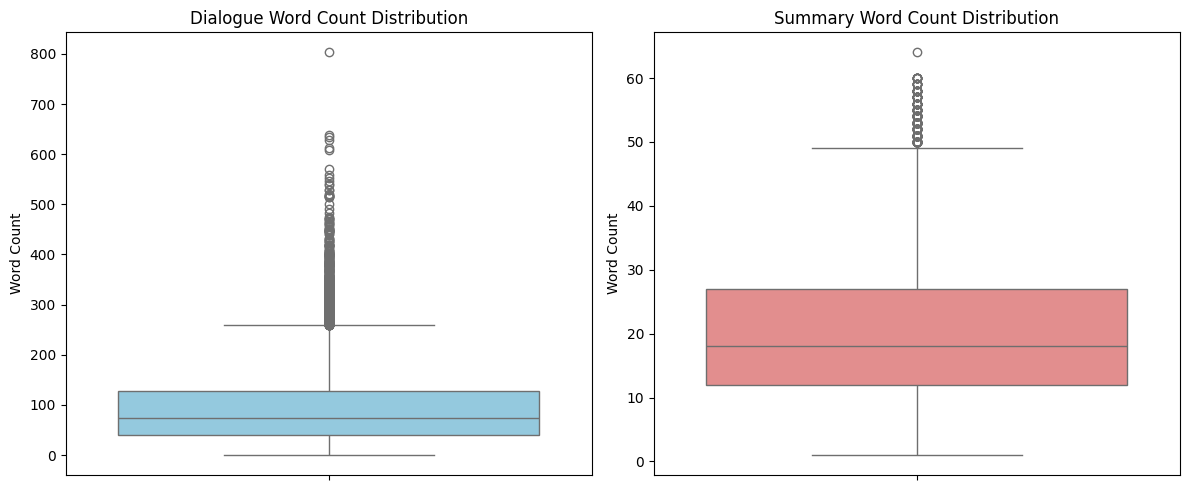

In [8]:
print("Train data word count distribution:")
plot_word_count_distribution(df_train)

Test data word count distribution:


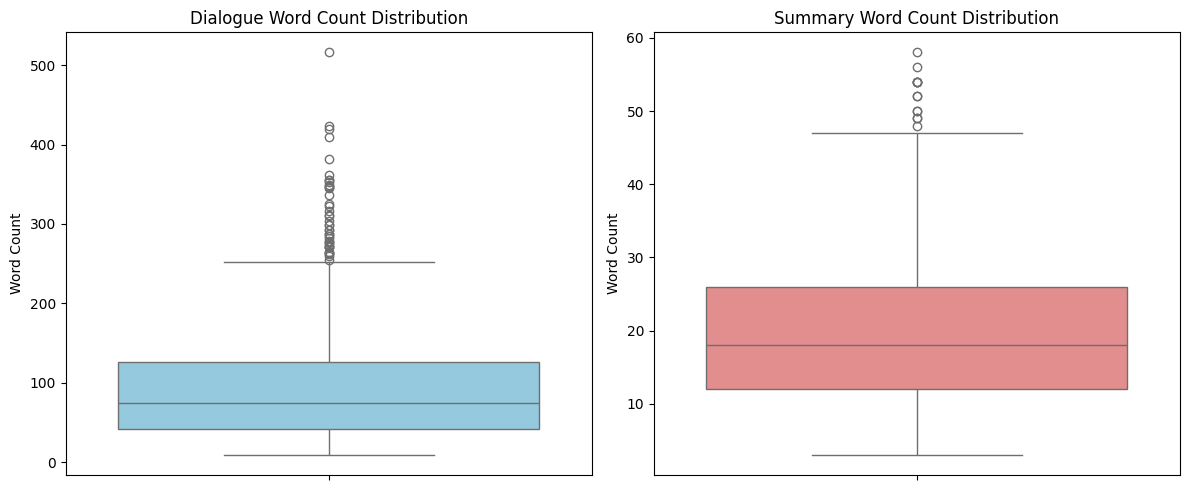

In [9]:
print("Test data word count distribution:")
plot_word_count_distribution(df_test)

## Extractive Summerisation using TextRank
1. Data Preprocessing
  - Format into a standardized structure
  - Remove noise and irrelevant content
2. Compute sentence importance score
  - key_item_score
  - position_score
  - penalise_factor
3. Compute similarity matrix
4. Run PageRank algorithm
5. Compute compression ratio.
6. Select top-ranked sentences
7. Reconstruct summary


In [4]:
!pip install yake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 1.8 MB/s eta 0:00:00


In [10]:
### Load necessary libraries ###
import re
import yake
import networkx as nx
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax
import spacy
from collections import Counter
import math
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
### Data Preprocessing ###
def extract_speaker(sentence):
    speaker = None
    match = re.match(r"(.+): (.+)", sentence.strip())
    if match:
      speaker, sentence = match.groups()
    return (speaker, sentence)

def preprocess_text(text):
    text = text.strip()
    # Remove emoticons
    ascii_emoji_pattern = re.compile(r'[:;=8][\-~]?[)\](DPOop\\/@|]')
    text = ascii_emoji_pattern.sub('', text)

    # Remove <...> tags eg. <file_image>
    placeholder_pattern = re.compile(r'<.*>')
    text = placeholder_pattern.sub(r'', text)

    # Normalise punctuation
    text = re.sub(r'([!?.,])\1{1,}', r'\1', text)
    text = re.sub(r'[!?.,]{2,}', lambda m: m.group(0)[-1], text)  # mixed punct → last one
    return text

def is_greeting(sentence):
    greeting_words = ["hi", "hello", "hey", "morning", "good", "great", "cool", "nice", "amazing", "okay", "thank", "thx"]
    if any(word in sentence.lower() for word in greeting_words):
        return True
    return False

def extract_structured_dialogue(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""

    # Split dialog w.r.t new line character
    sentences_original = text.splitlines()
    turns = list(map(extract_speaker, sentences_original))

    sentence_index = 0
    all_sentences = []

    for turn_index, (speaker, message) in enumerate(turns):
        if speaker is None or message is None:
            continue
        speaker = speaker.strip()
        message = preprocess_text(message)

        # Skip empty messages
        if not message:
            continue

        # Split into sentences
        sentences = []
        for sent in sent_tokenize(message):
            if bool(re.search(r'[a-zA-Z0-9]', text)) and not is_greeting(sent):
                sentences.append(sent)

        for sent_index, sentence in enumerate(sentences):
            sentence_index += 1
            all_sentences.append({
                'text': sentence,
                'speaker': speaker,
                'global_index': sentence_index,
                'turn_index': turn_index,
                'sentence_index': sent_index
            })

    return all_sentences

In [12]:
### Compute Sentence Importance ###
kw_extractor = yake.KeywordExtractor(lan="en", n=2, top=8, dedupLim=0.7, dedupFunc='seqm', windowsSize=1)

def extract_entities_and_keywords(sentences):
    full_text = " ".join(sentences)
    doc = nlp(full_text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Count frequency of each entity string
    entity_freq = Counter(ent for ent, label in entities)

    entity_importance = {}
    for text, label in entities:
      weight = 1.0
      if label in ['PERSON', 'ORG', 'GPE', 'LOC', 'DATE']:
          weight *= 1.5
      entity_importance[text.lower()] = weight * entity_freq[text]

    # normalize
    total = sum(entity_importance.values())
    entity_importance = {k: v / total for k, v in entity_importance.items()}


    raw_keywords = kw_extractor.extract_keywords(full_text)

    # Flip YAKE scores so that higher = more important
    # Normalize and store in a dict: {keyword: importance_score}
    keyword_importance = {}
    for kw, score in raw_keywords:
        if score == 0:
          continue
        keyword_importance[kw.lower()] = 1.0 / score

    # normalize flipped scores
    total = sum(keyword_importance.values())
    keyword_importance = {k: v / total for k, v in keyword_importance.items()}

    return entity_importance | keyword_importance


def calculate_sentence_importance(all_sentences, key_items):
    # Calculate importance for each sentence
    sentence_scores = np.ones(len(all_sentences))

    for i, sentence_info in enumerate(all_sentences):
        sentence = sentence_info['text'].lower()

        # Check for presence of key items (entities & keywords)
        key_item_score = 1.0
        for item_text, item_importance in key_items.items():
            if item_text in sentence:
                # Add importance score for each entity found
                key_item_score += item_importance

        # Position within turn
        position_score = 1.0
        if sentence_info['sentence_index'] == 0:  # First sentence in turn
            position_score *= 1.1

        penalise_factor = 1.0
        doc = nlp(sentence)
        total_tokens = len([t for t in doc if t.is_alpha])

        # Penalise for higher ratio of unimportant words (eg stopwords)
        stopwords = [t for t in doc if t.is_stop and t.is_alpha]
        stopword_count = len(stopwords)
        stopword_ratio = stopword_count / total_tokens if total_tokens > 0 else 0
        if stopword_ratio > 0.8:
            penalise_factor *= 0.8

        # Combine scores
        sentence_scores[i] = key_item_score * position_score * penalise_factor

    # Normalize scores
    sentence_scores = softmax(sentence_scores)

    return sentence_scores

In [13]:
### Create Sentence Embedding ###
def create_sentence_embeddings(sentences):
    try:
        # Try to use sentence-transformers if available
        model = SentenceTransformer('all-MiniLM-L6-v2')
        return model.encode(sentences)
    except:
        # Fallback to spaCy
        return np.array([nlp(text).vector for text in sentences])

In [14]:
### Compute Compression Ratio ###
def compute_compression_ratio(all_sentences):
    # Count sentences, turns, speakers, and words
    total_sentences = len(all_sentences)
    total_turns = all_sentences[-1]['turn_index'] + 1
    total_speakers = len(set(sentence['speaker'] for sentence in all_sentences))

    # Determine appropriate compression ratio based on complexity
    if total_sentences <= 10:
        # Short dialogues need less compression
        compression_ratio = 0.5
    elif total_sentences <= 20:
        compression_ratio = 0.4
    elif total_sentences <= 50:
        compression_ratio = 0.3
    else:
        # Long dialogues can be compressed more
        compression_ratio = 0.2


    if total_speakers > 3:  # Many speakers
        compression_ratio *= 1.1  # Less compression to preserve speaker contributions

    # Ensure compression ratio is within reasonable bounds
    compression_ratio = max(0.1, compression_ratio)

    return compression_ratio

In [15]:
### Reconstruct Summary Output ###
def reconstruct_summary(all_sentences, selected_indices):
    # Sort by original position
    selected_indices.sort()

    # Group selected sentences by turn
    selected_by_turn = {}
    for idx in selected_indices:
        sentence_info = all_sentences[idx]
        turn_idx = sentence_info['turn_index']

        if turn_idx not in selected_by_turn:
            selected_by_turn[turn_idx] = []

        selected_by_turn[turn_idx].append(sentence_info)

    # Build the summary by reconstructing turns with selected sentences
    summary_parts = []
    for turn_idx in sorted(selected_by_turn.keys()):
        # Get all selected sentences for this turn
        turn_sentences = selected_by_turn[turn_idx]

        # Get the speaker
        speaker = turn_sentences[0]['speaker']

        # Combine sentences
        combined_text = " ".join([sentence['text'] for sentence in turn_sentences])

        # Add to summary
        summary_parts.append(f"{speaker}: {combined_text}")

    summary = "\n".join(summary_parts)
    return summary

In [17]:
### Util - Graph visualisation ###
def visualize_sentence_graph(G, pagerank_scores):
    # Layout for the graph
    pos = nx.spring_layout(G, seed=42)

    # Node labels = PageRank scores (rounded)
    node_labels = {node: f"{node}\n{score:.3f}" for node, score in pagerank_scores.items()}

    # Edge labels = similarity weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

    # Draw nodes (scaled by importance)
    node_sizes = [pagerank_scores[n] * 10000 for n in G.nodes()]
    node_colors = [pagerank_scores[n] for n in G.nodes()]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.plasma)
    nx.draw_networkx_edges(G, pos, alpha=0.6)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="red", font_weight="bold")

    # Draw edge labels (similarity)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title("TextRank Sentence Graph with Similarity and PageRank Scores", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [18]:
### Main Function ###
def sentence_level_textrank(text):
    # STEP 1: Extract structured dialogue
    all_sentences = extract_structured_dialogue(text)
    sentence_texts = [sentence['text'] for sentence in all_sentences]

    # If dialogue is very short, return it as is
    total_sentences = len(all_sentences)
    if total_sentences <= 2:  # Very short dialogues are returned as is
        return reconstruct_summary(all_sentences, list(range(total_sentences)))


    # STEP 2: Extract named entities and keywords
    key_items = extract_entities_and_keywords(sentence_texts)

    # STEP 3: Calculate sentence importance
    sentence_scores = calculate_sentence_importance(all_sentences, key_items)

    # STEP 4: Create sentence embeddings
    embeddings = create_sentence_embeddings(sentence_texts)

    # STEP 5: Build similarity matrix
    similarity_matrix = cosine_similarity(embeddings)

    # Increase similarity score for same speaker
    for i in range(len(similarity_matrix)):
        for j in range(len(similarity_matrix)):
            if i != j:
                if all_sentences[i]['speaker'] == all_sentences[j]['speaker']:
                    similarity_matrix[i][j] *= 1.1

    for i, sentence_score in enumerate(sentence_scores):
        # If score is low, penalize the similarity values
        if sentence_score < 1 / len(sentence_scores):
            similarity_matrix[i, :] *= 0.7
            similarity_matrix[:, i] *= 0.7
    np.fill_diagonal(similarity_matrix, 1.0)

    # STEP 6: Create a graph and apply PageRank
    nx_graph = nx.from_numpy_array(similarity_matrix)
    personalization = {}
    for i, sentence_info in enumerate(all_sentences):
        importance = sentence_scores[i]
        personalization[i] = importance   # Apply personalization based on sentence scores

    scores = nx.pagerank(nx_graph, personalization=personalization, max_iter=300, tol=1e-04)
    #visualize_sentence_graph(nx_graph, scores)

    # STEP 7: Rank sentences by score
    ranked_sentences = sorted(((scores[i], i, sentence_info)
                              for i, sentence_info in enumerate(all_sentences)),
                             reverse=True)

    # STEP 8: Compute compression rate
    compression_ratio = compute_compression_ratio(all_sentences)

    # Select highest-scoring sentences up to max output length
    num_sentences = max(2, int(total_sentences * compression_ratio))
    selected_indices = []
    for _, idx, sentence_info in ranked_sentences:
        if len(selected_indices) >= num_sentences:
            break

        selected_indices.append(idx)

    # STEP 9: Reconstruct summary
    summary = reconstruct_summary(all_sentences, selected_indices)
    return summary


def summarize_dialogue(text):
    try:
      summary = sentence_level_textrank(text)

    except Exception as e:
      print(e)
      return text

    return summary

### Test on Random Test Sample

In [40]:
import random
idx = random.randint(1, 819)
test_sample = df_test.iloc[idx]
print("\n======== Dialogue =======")
print(test_sample["dialogue"])
summ = summarize_dialogue(test_sample["dialogue"])
print("\n======== summary =======")
print(summ)
print("\n======== ground truth summary =======")
print(test_sample['summary'])


======== Dialogue =======
Lenny: Babe, can you help me with something?
Bob: Sure, what's up?
Lenny: Which one should I pick?
Bob: Send me photos
Lenny:  <file_photo>
Lenny:  <file_photo>
Lenny:  <file_photo>
Bob: I like the first ones best
Lenny: But I already have purple trousers. Does it make sense to have two pairs?
Bob: I have four black pairs :D :D
Lenny: yeah, but shouldn't I pick a different color?
Bob: what matters is what you'll give you the most outfit options
Lenny: So I guess I'll buy the first or the third pair then
Bob: Pick the best quality then
Lenny: ur right, thx
Bob: no prob :)

======== summary =======
Lenny: But I already have purple trousers. Does it make sense to have two pairs?
Bob: I have four black pairs
Lenny: yeah, but shouldn't I pick a different color?
Bob: Pick the best quality then

======== ground truth summary =======
Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are o

### Generate Output to csv

In [ ]:
def generate_summ_textrank(test_df):
  test_df["extractive_summ"] = test_df["dialogue"].apply(summarize_dialogue)
  test_df.to_csv('./drive/MyDrive/CS5246_Final_Project/textrank_output.csv', index=False)
